# * * * * * Case Study - Spam Detection * * * * *

## * * * Pretrained Model - Bag of Words (BoW) * * *

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%%time
import re
import requests
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from collections import Counter
from sys import getsizeof
from tqdm import tqdm, tqdm_notebook

Wall time: 878 ms


### <<< Load the data >>>

In [3]:
### To read the useful csv file into DataFrame

df = pd.read_csv("data/email_data.csv")

df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


#### Describe the data

In [4]:
df.shape

(5171, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [6]:
df.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [7]:
df = df.drop('Unnamed: 0', axis=1)

df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\nthis deal is to ...,0


In [8]:
df.columns

Index(['label', 'text', 'label_num'], dtype='object')

In [9]:
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

### <<< Exploratory Data Analysis >>>

* Data Distribution of Target Variable i.e., label

In [10]:
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

In [11]:
df['label'].value_counts(normalize=True)

ham     0.710114
spam    0.289886
Name: label, dtype: float64

<AxesSubplot:xlabel='label', ylabel='count'>

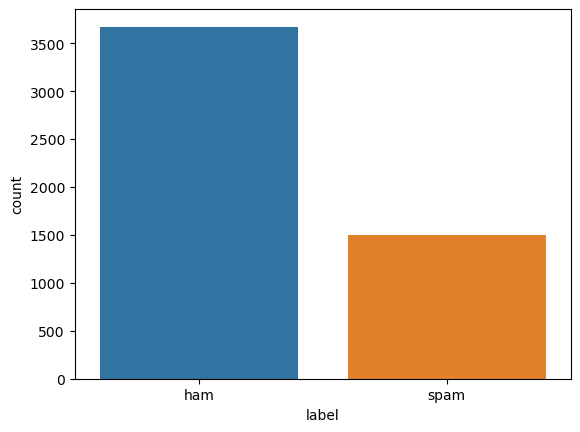

In [12]:
sns.countplot(x='label', data=df)

<AxesSubplot:ylabel='label'>

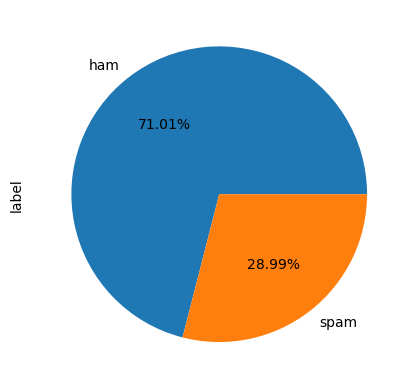

In [13]:
df['label'].value_counts().plot.pie(autopct='%.2f%%')

<AxesSubplot:xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 Most Frequent Words')

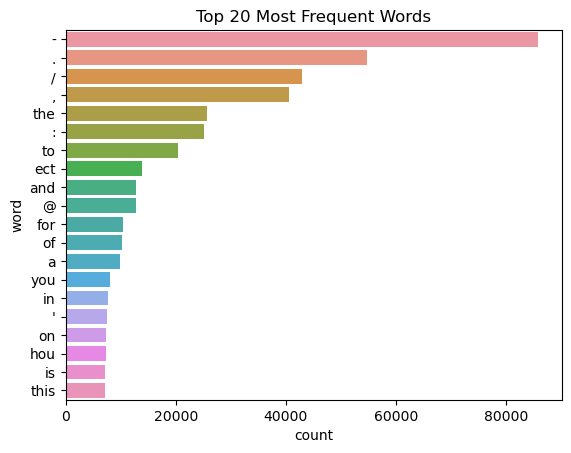

In [14]:
# Get all words in the text
all_words = " ".join(df['text'].values).split()
word_counts = Counter(all_words)

# Get the most common words
common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot the most common words
sns.barplot(data=common_words_df, x='count', y='word')
plt.title('Top 20 Most Frequent Words')
plt.show()

### <<< Split the data into Train and Test >>>

In [15]:
y = df["label"]
X = df[["text"]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4136, 1) (4136,)
(1035, 1) (1035,)


In [17]:
X_train.head()

,text
5132,Subject: april activity surveys\nwe are starti...
2067,Subject: message subject\nhey i ' am julie ^ _...
4716,Subject: txu fuels / sds nomination for may 20...
4710,Subject: re : richardson volumes nov 99 and de...
2268,Subject: a new era of online medical care .\na...


In [18]:
y_train.head()

5132     ham
2067    spam
4716     ham
4710     ham
2268    spam
Name: label, dtype: object

In [19]:
tqdm.pandas()

In [20]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [21]:
## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

In [22]:
def preprocess(raw_text, flag):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z.]", " ", raw_text)
    
    # change sentence to lower case
    sentence = sentence.lower()

    # Tokenization
    tokens = nltk.word_tokenize(sentence)
    
    # Stop word removal
    stop_words = list(set(stopwords.words('english')))
    custom_stop_words = ['subject', 'ect', 'hou', 'message', 'enron', 'nbsp']
    stop_words = stop_words + custom_stop_words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in filtered_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return pd.Series([" ".join(clean_tokens), len(clean_tokens)])

In [23]:
temp_df = X_train['text'].progress_apply(lambda x: preprocess(x, 'stem'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 4136/4136 [00:30<00:00, 134.75it/s]


,0,1
5132,april activ survey start collect data april . ...,95
2067,hey juli . turn high school senior houston tx ...,52
4716,txu fuel sd nomin may attach may nomin take ga...,37
4710,richardson volum nov dec meter nick sure happe...,109
2268,new era onlin medic care . new era onlin medic...,42


In [24]:
temp_df.columns = ['clean_text_stem', 'text_length_stem']

temp_df.head()

,clean_text_stem,text_length_stem
5132,april activ survey start collect data april . ...,95
2067,hey juli . turn high school senior houston tx ...,52
4716,txu fuel sd nomin may attach may nomin take ga...,37
4710,richardson volum nov dec meter nick sure happe...,109
2268,new era onlin medic care . new era onlin medic...,42


In [25]:
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

,text,clean_text_stem,text_length_stem
5132,Subject: april activity surveys\nwe are starti...,april activ survey start collect data april . ...,95
2067,Subject: message subject\nhey i ' am julie ^ _...,hey juli . turn high school senior houston tx ...,52
4716,Subject: txu fuels / sds nomination for may 20...,txu fuel sd nomin may attach may nomin take ga...,37
4710,Subject: re : richardson volumes nov 99 and de...,richardson volum nov dec meter nick sure happe...,109
2268,Subject: a new era of online medical care .\na...,new era onlin medic care . new era onlin medic...,42


In [26]:
temp_df = X_train['text'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 4136/4136 [00:23<00:00, 178.89it/s]


,0,1
5132,april activity survey starting collect data ap...,95
2067,hey julie . turned high school senior houston ...,52
4716,txu fuel sd nomination may attached may nomina...,37
4710,richardson volume nov dec meter nick sure happ...,109
2268,new era online medical care . new era online m...,42


In [27]:
temp_df.columns = ['clean_text_lemma', 'text_length_lemma']

temp_df.head()

,clean_text_lemma,text_length_lemma
5132,april activity survey starting collect data ap...,95
2067,hey julie . turned high school senior houston ...,52
4716,txu fuel sd nomination may attached may nomina...,37
4710,richardson volume nov dec meter nick sure happ...,109
2268,new era online medical care . new era online m...,42


In [28]:
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

,text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
5132,Subject: april activity surveys\nwe are starti...,april activ survey start collect data april . ...,95,april activity survey starting collect data ap...,95
2067,Subject: message subject\nhey i ' am julie ^ _...,hey juli . turn high school senior houston tx ...,52,hey julie . turned high school senior houston ...,52
4716,Subject: txu fuels / sds nomination for may 20...,txu fuel sd nomin may attach may nomin take ga...,37,txu fuel sd nomination may attached may nomina...,37
4710,Subject: re : richardson volumes nov 99 and de...,richardson volum nov dec meter nick sure happe...,109,richardson volume nov dec meter nick sure happ...,109
2268,Subject: a new era of online medical care .\na...,new era onlin medic care . new era onlin medic...,42,new era online medical care . new era online m...,42


In [29]:
y_train

5132     ham
2067    spam
4716     ham
4710     ham
2268    spam
        ... 
4426     ham
466      ham
3092    spam
3772     ham
860      ham
Name: label, Length: 4136, dtype: object

In [30]:
X_test.head()

,text
1566,"Subject: hpl nom for march 30 , 2001\n( see at..."
1988,Subject: online pharxmacy 80 % off all meds\nd...
1235,Subject: re : nom / actual volume for april 17...
2868,Subject: re : meter 8740 dec 99\nrobert and i ...
4903,Subject: re : coastal oil & gas corporation\nm...


In [31]:
temp_df = X_test['text'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 1035/1035 [00:05<00:00, 182.20it/s]


,0,1
1566,hpl nom march see attached file hplno . xl hpl...,12
1988,online pharxmacy med disscount phafrmacy onlsi...,2642
1235,nom actual volume april th agree eileen ponton...,45
2868,meter dec robert put head together decided ent...,307
4903,coastal oil gas corporation melissa deal creat...,1078


In [32]:
temp_df.columns = ['clean_text_lemma', 'text_length_lemma']

temp_df.head()

,clean_text_lemma,text_length_lemma
1566,hpl nom march see attached file hplno . xl hpl...,12
1988,online pharxmacy med disscount phafrmacy onlsi...,2642
1235,nom actual volume april th agree eileen ponton...,45
2868,meter dec robert put head together decided ent...,307
4903,coastal oil gas corporation melissa deal creat...,1078


In [33]:
X_test = pd.concat([X_test, temp_df], axis=1)

X_test.head()

,text,clean_text_lemma,text_length_lemma
1566,"Subject: hpl nom for march 30 , 2001\n( see at...",hpl nom march see attached file hplno . xl hpl...,12
1988,Subject: online pharxmacy 80 % off all meds\nd...,online pharxmacy med disscount phafrmacy onlsi...,2642
1235,Subject: re : nom / actual volume for april 17...,nom actual volume april th agree eileen ponton...,45
2868,Subject: re : meter 8740 dec 99\nrobert and i ...,meter dec robert put head together decided ent...,307
4903,Subject: re : coastal oil & gas corporation\nm...,coastal oil gas corporation melissa deal creat...,1078


<Figure size 3000x2000 with 0 Axes>

Text(0.5, 1.0, 'Ham Word Cloud')

(-0.5, 1599.5, 799.5, -0.5)

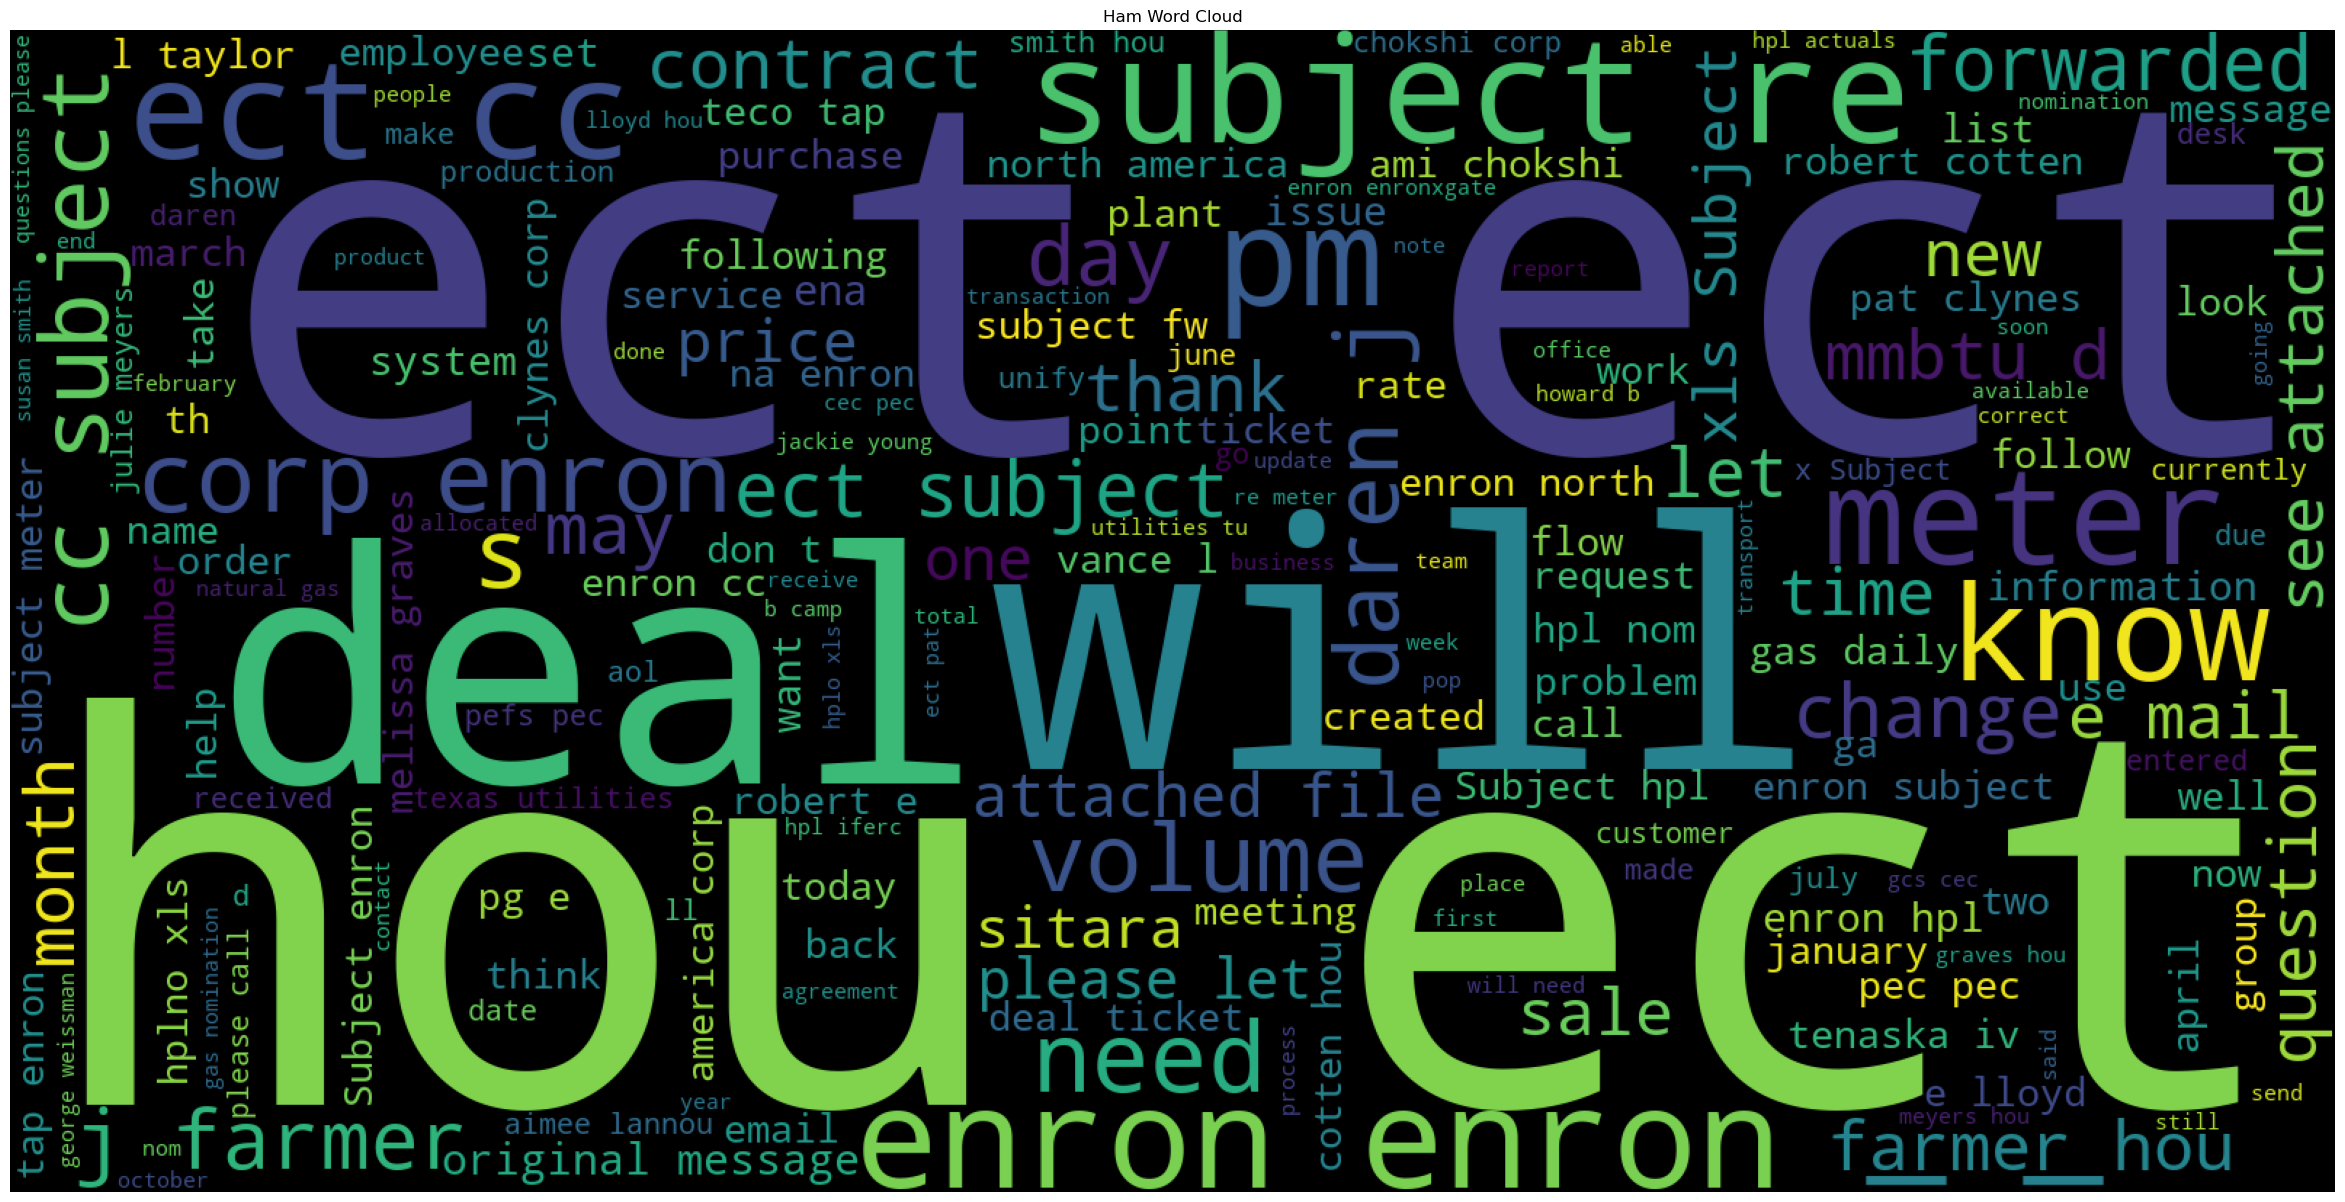

In [34]:
# Word cloud for ham messages
ham_text = " ".join(df[df['label'] == 'ham']['text'].values)
ham_wordcloud = WordCloud(width=1600, height=800).generate(ham_text)
plt.figure(1,figsize=(30,20))
plt.title("Ham Word Cloud")
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.show()

<Figure size 3000x2000 with 0 Axes>

Text(0.5, 1.0, 'Spam Word Cloud')

(-0.5, 1599.5, 799.5, -0.5)

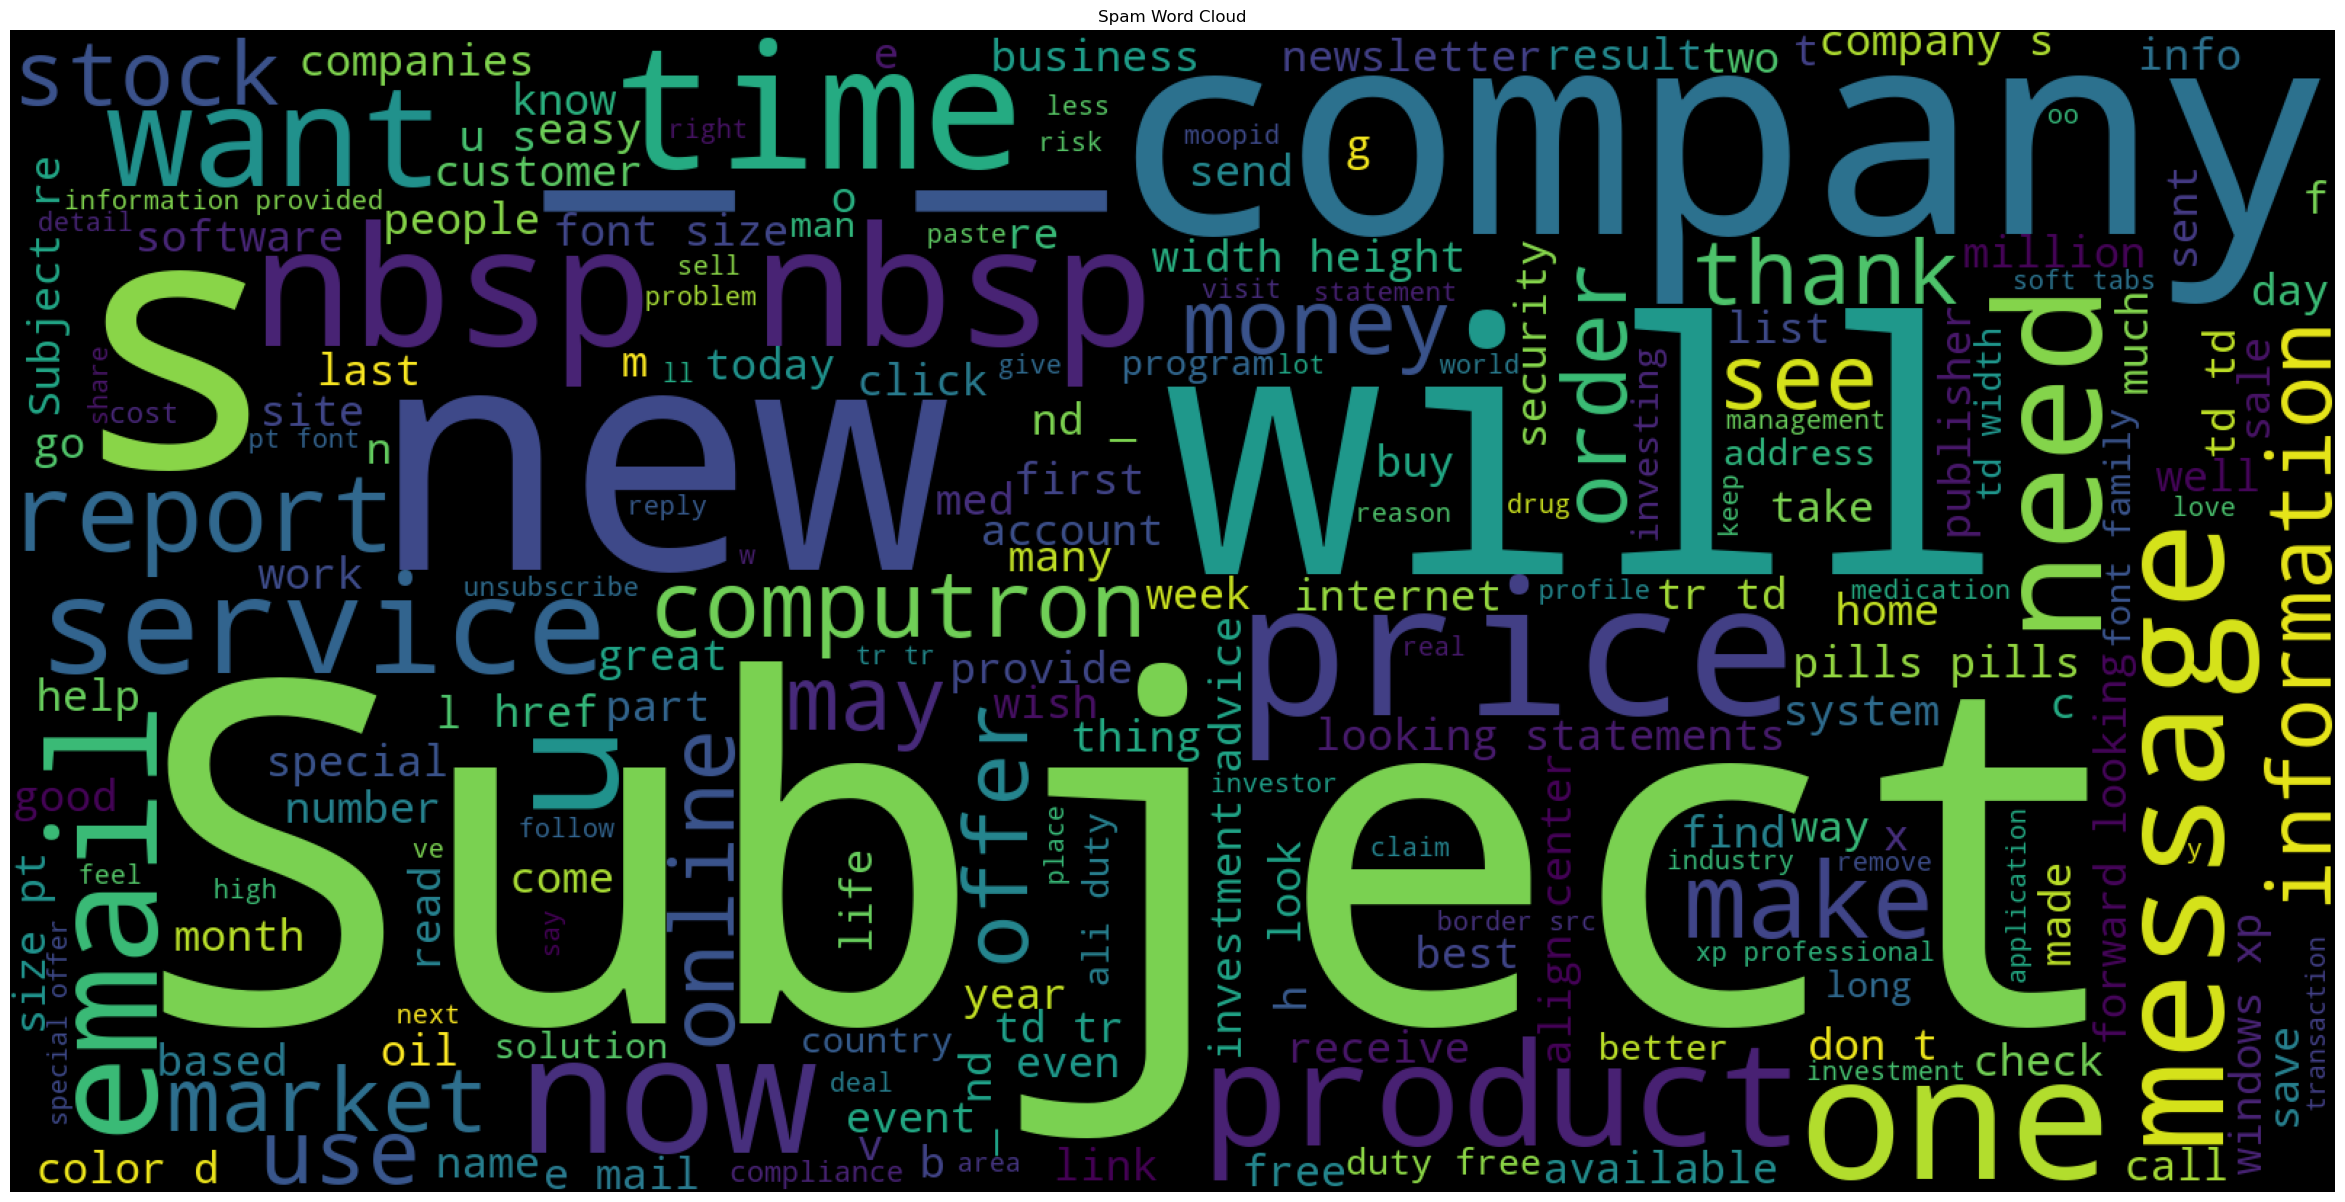

In [36]:
# Word cloud for spam messages
spam_text = " ".join(df[df['label'] == 'spam']['text'].values)
spam_wordcloud = WordCloud(width=1600, height=800).generate(ham_text)
plt.figure(1,figsize=(30,20))
plt.title("Spam Word Cloud")
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.show()

## Converting Text to Numerical vectors - BOW Representation

In [37]:
X_train.head()

,text,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
5132,Subject: april activity surveys\nwe are starti...,april activ survey start collect data april . ...,95,april activity survey starting collect data ap...,95
2067,Subject: message subject\nhey i ' am julie ^ _...,hey juli . turn high school senior houston tx ...,52,hey julie . turned high school senior houston ...,52
4716,Subject: txu fuels / sds nomination for may 20...,txu fuel sd nomin may attach may nomin take ga...,37,txu fuel sd nomination may attached may nomina...,37
4710,Subject: re : richardson volumes nov 99 and de...,richardson volum nov dec meter nick sure happe...,109,richardson volume nov dec meter nick sure happ...,109
2268,Subject: a new era of online medical care .\na...,new era onlin medic care . new era onlin medic...,42,new era online medical care . new era online m...,42


In [38]:
vocab = CountVectorizer()

In [39]:
X_train_bow = vocab.fit_transform(X_train['text'])

In [40]:
X_train_bow

<4136x45240 sparse matrix of type '<class 'numpy.int64'>'
	with 366436 stored elements in Compressed Sparse Row format>

In [41]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 45240
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (4136, 45240)


In [42]:
print(X_train_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]]


In [43]:
from sys import getsizeof

print(type(X_train_bow))
print(getsizeof(X_train_bow), "Bytes")

<class 'scipy.sparse._csr.csr_matrix'>
48 Bytes


In [44]:
from sys import getsizeof

print(type(X_train_bow.toarray()))
print(getsizeof(X_train_bow.toarray()), "Bytes")

<class 'numpy.ndarray'>
1496901248 Bytes


In [45]:
X_test.head()

,text,clean_text_lemma,text_length_lemma
1566,"Subject: hpl nom for march 30 , 2001\n( see at...",hpl nom march see attached file hplno . xl hpl...,12
1988,Subject: online pharxmacy 80 % off all meds\nd...,online pharxmacy med disscount phafrmacy onlsi...,2642
1235,Subject: re : nom / actual volume for april 17...,nom actual volume april th agree eileen ponton...,45
2868,Subject: re : meter 8740 dec 99\nrobert and i ...,meter dec robert put head together decided ent...,307
4903,Subject: re : coastal oil & gas corporation\nm...,coastal oil gas corporation melissa deal creat...,1078


In [46]:
X_test_bow = vocab.transform(X_test['text'])

### Logistic Regression

In [47]:
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

LogisticRegression()

In [48]:
y_test_pred = classifier.predict(X_test_bow)

In [49]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='ham'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9806763285024155
F1 Score :  0.9865229110512129
Classification Report :
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       742
        spam       0.97      0.97      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

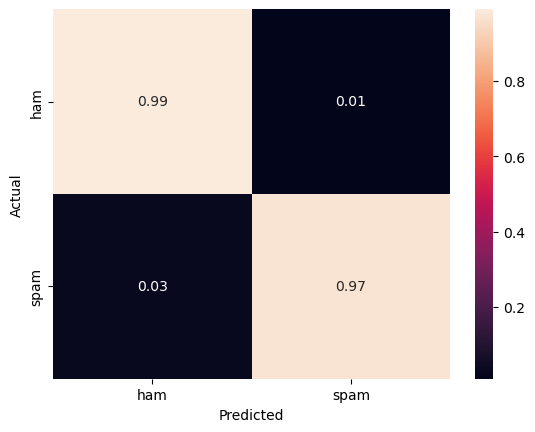

In [50]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### KNN

In [51]:
classifier = KNeighborsClassifier()
classifier.fit(X_train_bow, y_train)

KNeighborsClassifier()

In [52]:
y_test_pred = classifier.predict(X_test_bow)

In [53]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='ham'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8618357487922705
F1 Score :  0.8995080815179198
Classification Report :
              precision    recall  f1-score   support

         ham       0.94      0.86      0.90       742
        spam       0.71      0.86      0.78       293

    accuracy                           0.86      1035
   macro avg       0.83      0.86      0.84      1035
weighted avg       0.88      0.86      0.87      1035



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

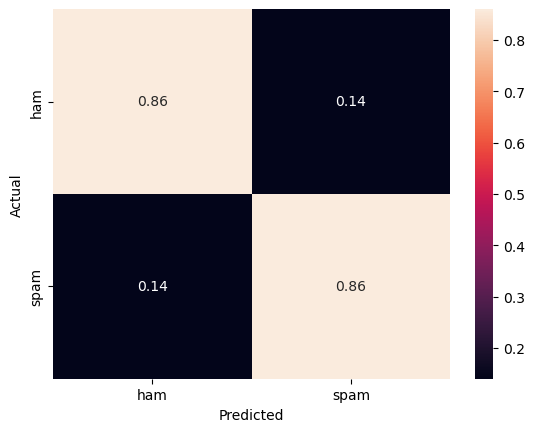

In [54]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### MultinomialNB

In [55]:
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

MultinomialNB()

In [56]:
y_test_pred = classifier.predict(X_test_bow)

In [57]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='ham'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9719806763285024
F1 Score :  0.980497646267653
Classification Report :
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       742
        spam       0.96      0.95      0.95       293

    accuracy                           0.97      1035
   macro avg       0.97      0.96      0.97      1035
weighted avg       0.97      0.97      0.97      1035



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

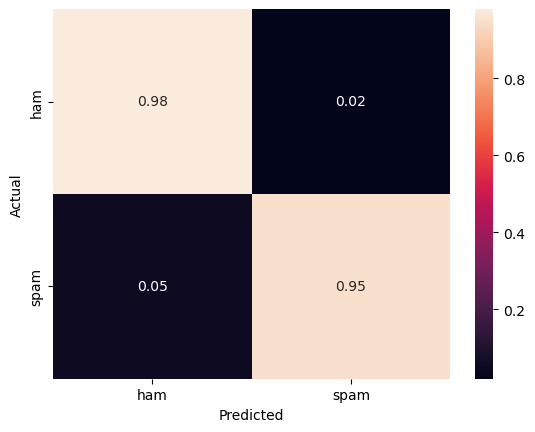

In [58]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### SVM (SVC)

In [59]:
classifier = SVC()
classifier.fit(X_train_bow, y_train)

SVC()

In [60]:
y_test_pred = classifier.predict(X_test_bow)

In [61]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='ham'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9652173913043478
F1 Score :  0.975609756097561
Classification Report :
              precision    recall  f1-score   support

         ham       0.98      0.97      0.98       742
        spam       0.93      0.95      0.94       293

    accuracy                           0.97      1035
   macro avg       0.95      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

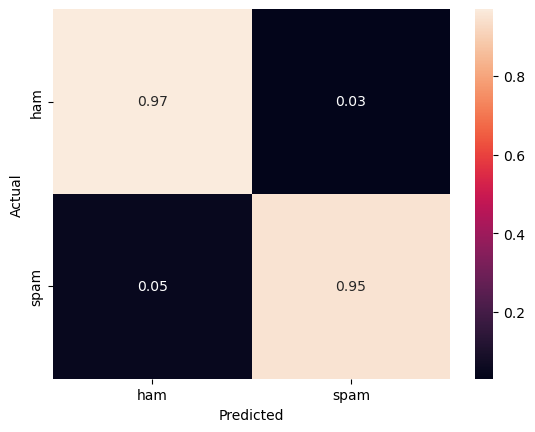

In [62]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [63]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train_bow, y_train)

DecisionTreeClassifier()

In [64]:
y_test_pred = classifier.predict(X_test_bow)

In [65]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='ham'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9439613526570049
F1 Score :  0.9603825136612021
Classification Report :
              precision    recall  f1-score   support

         ham       0.97      0.95      0.96       742
        spam       0.88      0.94      0.90       293

    accuracy                           0.94      1035
   macro avg       0.92      0.94      0.93      1035
weighted avg       0.95      0.94      0.94      1035



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

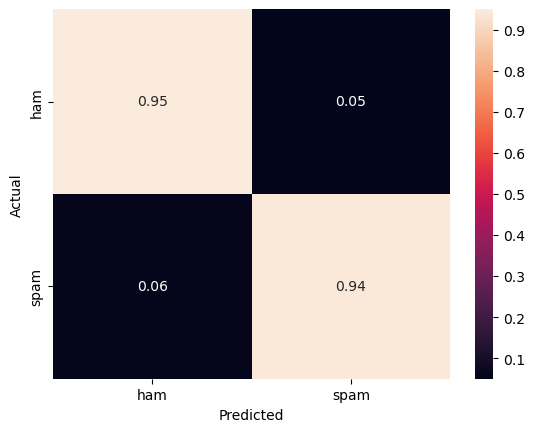

In [66]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Random Forest

In [67]:
classifier = RandomForestClassifier()
classifier.fit(X_train_bow, y_train)

RandomForestClassifier()

In [68]:
y_test_pred = classifier.predict(X_test_bow)

In [69]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='ham'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.970048309178744
F1 Score :  0.9792364367046216
Classification Report :
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       742
        spam       0.96      0.93      0.95       293

    accuracy                           0.97      1035
   macro avg       0.97      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

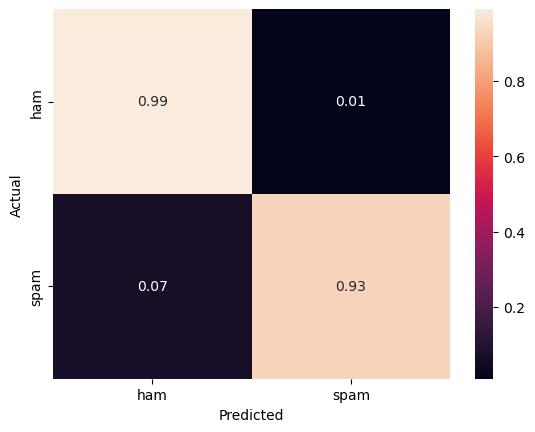

In [70]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')